# Model Comparison on Test Set

This notebook loads trained models from their `.pkl` files and evaluates them on the **test set** (2022-10 to 2023-09).

Usage:
1. Add your models to the `MODELS` dictionary below
2. Run all cells to get test set performance comparison

## 1. Setup & Configuration

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Any
from datetime import datetime
from dateutil.relativedelta import relativedelta
from functools import lru_cache
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check if running on Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')
    GRAPH_DIR = '/content/drive/MyDrive/CS224W/graphs'
    PROJECT_DIR = Path('/content/drive/MyDrive/CS224W')
else:
    print("Running locally")
    GRAPH_DIR = '../data/processed/graphs'
    PROJECT_DIR = Path('..')

RESULTS_DIR = PROJECT_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

Running locally


In [ ]:
# ============================================================================
# MODEL CONFIGURATION
# ============================================================================
# Add your models here as {"Model Name": "path/to/model.pkl"}
# The notebook will load and evaluate each model on the test set
#
# Expected formats:
# - Baseline models (.pkl): dict with 'linear_models', 'rf_models', 'scaler', 'norm_stats'
# - GNN models (.pt): PyTorch model state dict
# ============================================================================

MODELS = {
    "Baseline Models": "../results/baseline/baseline_models.pkl",
    # "GNN Model": "../results/gnn/best_model.pt",
}

print(f"Models to evaluate: {list(MODELS.keys())}")

Models to evaluate: ['Baseline Models']


## 2. Test Dataset

In [3]:
class TemporalGraphDataset:
    """
    Dataset for loading temporal sequences of community graphs.
    Uses the same split definitions as baselines.ipynb.
    """
    
    def __init__(
        self,
        graph_dir: str,
        split: str = 'test',
        sequence_length: int = 12,
        prediction_horizon: int = 6,
        max_samples: int = None,
        cache_size: int = 500
    ):
        self.graph_dir = Path(graph_dir)
        self.split = split
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        
        # Temporal splits (same as baselines.ipynb)
        self.split_ranges = {
            'train': ('2014-01', '2020-06'),
            'val':   ('2020-07', '2022-09'),
            'test':  ('2022-10', '2023-09')
        }
        
        # Build sample index
        print(f"Building {split} sample index...")
        self.samples = self._build_sample_index()
        print(f"  Found {len(self.samples)} samples")
        
        if max_samples and len(self.samples) > max_samples:
            import random
            random.shuffle(self.samples)
            self.samples = self.samples[:max_samples]
            print(f"  Limited to {max_samples} samples")
        
        # Initialize normalization stats
        self.norm_stats = None
        
        # Create cached loader
        @lru_cache(maxsize=cache_size)
        def _cached_load(community: str, month: str):
            path = self.graph_dir / community / f"{month}.pt"
            return torch.load(path, weights_only=False, map_location='cpu')
        
        self._load_graph = _cached_load
    
    def _build_sample_index(self) -> List[Dict]:
        """Build index of all valid temporal sequences."""
        samples = []
        start_month, end_month = self.split_ranges[self.split]
        min_graphs = self.sequence_length + self.prediction_horizon
        
        for community_dir in sorted(self.graph_dir.iterdir()):
            if not community_dir.is_dir():
                continue
            
            available_months = sorted([f.stem for f in community_dir.glob('*.pt')])
            if len(available_months) < min_graphs:
                continue
            
            for i, month_t in enumerate(available_months):
                if not (start_month <= month_t <= end_month):
                    continue
                if i < self.sequence_length - 1:
                    continue
                
                target_idx = i + self.prediction_horizon
                if target_idx >= len(available_months):
                    continue
                
                seq_start = i - self.sequence_length + 1
                seq_months = available_months[seq_start:i+1]
                target_month = available_months[target_idx]
                
                if self._is_consecutive(seq_months, target_month):
                    samples.append({
                        'community': community_dir.name,
                        'sequence_months': seq_months,
                        'target_month': target_month
                    })
        return samples
    
    def _is_consecutive(self, seq_months, target_month):
        """Check if months form consecutive sequence."""
        try:
            dates = [datetime.strptime(m, '%Y-%m') for m in seq_months]
            for i in range(1, len(dates)):
                if dates[i] != dates[i-1] + relativedelta(months=1):
                    return False
            target_date = datetime.strptime(target_month, '%Y-%m')
            expected = dates[-1] + relativedelta(months=self.prediction_horizon)
            return target_date == expected
        except:
            return False
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load sequence of graphs
        graphs = []
        for month in sample['sequence_months']:
            graph = self._load_graph(sample['community'], month)
            graphs.append(graph)
        
        # Load target graph
        target_graph = self._load_graph(sample['community'], sample['target_month'])
        targets = target_graph.y
        
        # Get current values (from last graph in sequence) for delta prediction
        current_values = graphs[-1].y
        
        return graphs, targets, current_values

In [4]:
# Create test dataset
test_dataset = TemporalGraphDataset(
    graph_dir=GRAPH_DIR,
    split='test',
    max_samples=None  # Use all test samples
)

print(f"\nTest dataset: {len(test_dataset)} samples")

Building test sample index...
  Found 2002 samples

Test dataset: 2002 samples


## 3. Feature Extraction (for Baseline Models)

In [5]:
def extract_graph_features(graph) -> np.ndarray:
    """
    Extract flat feature vector from a single heterogeneous graph.
    Same as baselines.ipynb.
    """
    features = []
    
    # User features
    user_x = graph['user'].x.numpy()
    if len(user_x) > 0:
        features.extend(user_x.mean(axis=0))
        features.extend(user_x.std(axis=0))
        features.append(len(user_x))
    else:
        features.extend([0] * (user_x.shape[1] * 2 + 1))
    
    # Tag features
    tag_x = graph['tag'].x.numpy()
    if len(tag_x) > 0:
        features.extend(tag_x.mean(axis=0))
        features.extend(tag_x.std(axis=0))
        features.append(len(tag_x))
    else:
        features.extend([0] * (tag_x.shape[1] * 2 + 1))
    
    # Edge counts
    for edge_type in [('user', 'posts_in', 'tag'), ('user', 'answers', 'user')]:
        if edge_type in graph.edge_types:
            features.append(graph[edge_type].edge_index.shape[1])
        else:
            features.append(0)
    
    # Historical target metrics
    if hasattr(graph, 'y') and graph.y is not None:
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in graph.y:
                features.append(float(graph.y[key]))
            else:
                features.append(0)
    else:
        features.extend([0, 0, 0])
    
    return np.array(features, dtype=np.float32)


def extract_sequence_features(graphs: List, include_trends: bool = True) -> np.ndarray:
    """
    Extract features from a sequence of 12 monthly graphs.
    Same as baselines.ipynb.
    """
    graph_features = [extract_graph_features(g) for g in graphs]
    graph_features = np.array(graph_features)
    
    features = []
    
    # Last graph features
    features.extend(graph_features[-1])
    
    # Mean features across sequence
    features.extend(graph_features.mean(axis=0))
    
    # Std features across sequence
    features.extend(graph_features.std(axis=0))
    
    if include_trends:
        x = np.arange(len(graphs))
        for i in range(graph_features.shape[1]):
            y = graph_features[:, i]
            if np.std(y) > 1e-8:
                slope = np.polyfit(x, y, 1)[0]
            else:
                slope = 0
            features.append(slope)
    
    return np.array(features, dtype=np.float32)

In [6]:
# Extract features for test set
print("Extracting test features...")

X_test = []
y_test = {'qpd': [], 'answer_rate': [], 'retention': []}
y_current = {'qpd': [], 'answer_rate': [], 'retention': []}  # For delta prediction

for i in tqdm(range(len(test_dataset)), desc='Test'):
    graphs, targets, current = test_dataset[i]
    
    features = extract_sequence_features(graphs)
    X_test.append(features)
    
    for key in y_test:
        y_test[key].append(float(targets[key]) if key in targets else 0)
        y_current[key].append(float(current[key]) if key in current else 0)

X_test = np.array(X_test)
for key in y_test:
    y_test[key] = np.array(y_test[key])
    y_current[key] = np.array(y_current[key])

print(f"\nTest features shape: {X_test.shape}")
print(f"Test samples: {len(y_test['qpd'])}")

Extracting test features...


Test:   0%|          | 0/2002 [00:00<?, ?it/s]


Test features shape: (2002, 124)
Test samples: 2002


## 4. Evaluation Functions

In [14]:
def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> Dict:
    """
    Evaluate predictions using MAE, RMSE, R².
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }


def print_results(results: Dict, model_name: str):
    """Pretty print evaluation results."""
    print(f"\n{'='*70}")
    print(f"{model_name} - Test Set Results")
    print("="*70)
    print(f"{'Metric':<15} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
    print("-"*51)
    
    mean_mae, mean_rmse, mean_r2 = 0, 0, 0
    for key in ['qpd', 'answer_rate', 'retention']:
        if key in results:
            r = results[key]
            print(f"{key:<15} {r['mae']:<12.4f} {r['rmse']:<12.4f} {r['r2']:<12.4f}")
            mean_mae += r['mae']
            mean_rmse += r['rmse']
            mean_r2 += r['r2']
    
    print("-"*51)
    print(f"{'MEAN':<15} {mean_mae/3:<12.4f} {mean_rmse/3:<12.4f} {mean_r2/3:<12.4f}")
    print("="*70)
    
    return {'mae': mean_mae/3, 'rmse': mean_rmse/3, 'r2': mean_r2/3}

## 5. Evaluate Baseline Models

In [15]:
def evaluate_baseline_models(model_path: str, X_test: np.ndarray, y_test: Dict, y_current: Dict) -> Dict:
    """
    Evaluate baseline models (Linear, RF, etc.) from pickle file.
    
    Args:
        model_path: Path to the baseline_models.pkl file
        X_test: Test features
        y_test: Dict of test targets
        y_current: Dict of current values (for delta models)
    
    Returns:
        Dict of results for each model type
    """
    with open(model_path, 'rb') as f:
        saved = pickle.load(f)
    
    linear_models = saved.get('linear_models', {})
    rf_models = saved.get('rf_models', {})
    scaler = saved.get('scaler')
    norm_stats = saved.get('norm_stats', {})
    
    # Also check for delta models
    delta_linear_models = saved.get('delta_linear_models', {})
    delta_rf_models = saved.get('delta_rf_models', {})
    delta_norm_stats = saved.get('delta_norm_stats', {})
    
    # Scale test features
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test
    
    all_results = {}
    
    # Evaluate Linear Regression
    if linear_models:
        results = {}
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in linear_models:
                y_pred_norm = linear_models[key].predict(X_test_scaled)
                # Denormalize
                if key in norm_stats:
                    y_pred = y_pred_norm * norm_stats[key]['std'] + norm_stats[key]['mean']
                else:
                    y_pred = y_pred_norm
                results[key] = evaluate_predictions(y_test[key], y_pred)
        
        if results:
            all_results['Linear Regression'] = results
    
    # Evaluate Random Forest
    if rf_models:
        results = {}
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in rf_models:
                y_pred_norm = rf_models[key].predict(X_test_scaled)
                # Denormalize
                if key in norm_stats:
                    y_pred = y_pred_norm * norm_stats[key]['std'] + norm_stats[key]['mean']
                else:
                    y_pred = y_pred_norm
                results[key] = evaluate_predictions(y_test[key], y_pred)
        
        if results:
            all_results['Random Forest'] = results
    
    # Evaluate Delta Linear
    if delta_linear_models:
        results = {}
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in delta_linear_models:
                delta_pred_norm = delta_linear_models[key].predict(X_test_scaled)
                # Denormalize delta and add to current
                if key in delta_norm_stats:
                    delta_pred = delta_pred_norm * delta_norm_stats[key]['std'] + delta_norm_stats[key]['mean']
                else:
                    delta_pred = delta_pred_norm
                y_pred = y_current[key] + delta_pred
                results[key] = evaluate_predictions(y_test[key], y_pred)
        
        if results:
            all_results['Δ Linear'] = results
    
    # Evaluate Delta Random Forest
    if delta_rf_models:
        results = {}
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in delta_rf_models:
                delta_pred_norm = delta_rf_models[key].predict(X_test_scaled)
                # Denormalize delta and add to current
                if key in delta_norm_stats:
                    delta_pred = delta_pred_norm * delta_norm_stats[key]['std'] + delta_norm_stats[key]['mean']
                else:
                    delta_pred = delta_pred_norm
                y_pred = y_current[key] + delta_pred
                results[key] = evaluate_predictions(y_test[key], y_pred)
        
        if results:
            all_results['Δ Random Forest'] = results
    
    # Add Naive baseline (predict current value)
    naive_results = {}
    for key in ['qpd', 'answer_rate', 'retention']:
        naive_results[key] = evaluate_predictions(y_test[key], y_current[key])
    all_results['Naive'] = naive_results
    
    return all_results

## 6. Run Evaluation

In [16]:
# Store all results
all_model_results = {}

for model_name, model_path in MODELS.items():
    print(f"\n{'#'*70}")
    print(f"# Evaluating: {model_name}")
    print(f"# Path: {model_path}")
    print(f"{'#'*70}")
    
    model_path = Path(model_path)
    
    if not model_path.exists():
        print(f"WARNING: Model file not found: {model_path}")
        continue
    
    # Check file type
    if model_path.suffix == '.pkl':
        # Baseline models
        results = evaluate_baseline_models(str(model_path), X_test, y_test, y_current)
        
        for sub_model_name, sub_results in results.items():
            full_name = sub_model_name
            all_model_results[full_name] = sub_results
            mean_metrics = print_results(sub_results, full_name)
    
    elif model_path.suffix == '.pt':
        # PyTorch GNN model - needs custom loading logic
        print(f"GNN model loading not yet implemented for: {model_path}")
        print("Add your GNN evaluation logic here.")
    
    else:
        print(f"Unknown model format: {model_path.suffix}")


######################################################################
# Evaluating: Baseline Models
# Path: ../results/baseline/baseline_models.pkl
######################################################################

Linear Regression - Test Set Results
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.6566       2.6704       0.9819      
answer_rate     0.1087       0.1547       0.0702      
retention       0.0797       0.1226       0.2336      
---------------------------------------------------
MEAN            0.6150       0.9826       0.4286      

Random Forest - Test Set Results
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.6494       9.5714       0.7671      
answer_rate     0.1092       0.1508       0.1168      
retention       0.0777       0.1215       0.2482      
---------------------------------------------------
MEAN

## 7. Comparison Summary

In [17]:
# Build comparison dataframe
comparison_data = []

for model_name, results in all_model_results.items():
    for metric in ['qpd', 'answer_rate', 'retention']:
        if metric in results:
            comparison_data.append({
                'Model': model_name,
                'Target': metric,
                'MAE': results[metric]['mae'],
                'RMSE': results[metric]['rmse'],
                'R²': results[metric]['r2']
            })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + "="*80)
    print("TEST SET RESULTS - All Models")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # Mean performance across all targets
    print("\n" + "="*80)
    print("MEAN PERFORMANCE (across all targets)")
    print("="*80)
    mean_comparison = comparison_df.groupby('Model')[['MAE', 'RMSE', 'R²']].mean()
    mean_comparison = mean_comparison.sort_values('R²', ascending=False)
    print(mean_comparison.to_string())
else:
    print("No results to compare.")


TEST SET RESULTS - All Models
            Model      Target      MAE     RMSE        R²
Linear Regression         qpd 1.656576 2.670424  0.981872
Linear Regression answer_rate 0.108685 0.154707  0.070191
Linear Regression   retention 0.079702 0.122626  0.233612
    Random Forest         qpd 1.649351 9.571414  0.767111
    Random Forest answer_rate 0.109192 0.150780  0.116789
    Random Forest   retention 0.077749 0.121451  0.248229
            Naive         qpd 1.039418 2.356979  0.985878
            Naive answer_rate 0.110372 0.165805 -0.067998
            Naive   retention 0.090314 0.140712 -0.009124

MEAN PERFORMANCE (across all targets)
                        MAE      RMSE        R²
Model                                          
Linear Regression  0.614988  0.982586  0.428558
Random Forest      0.612097  3.281215  0.377376
Naive              0.413368  0.887832  0.302918


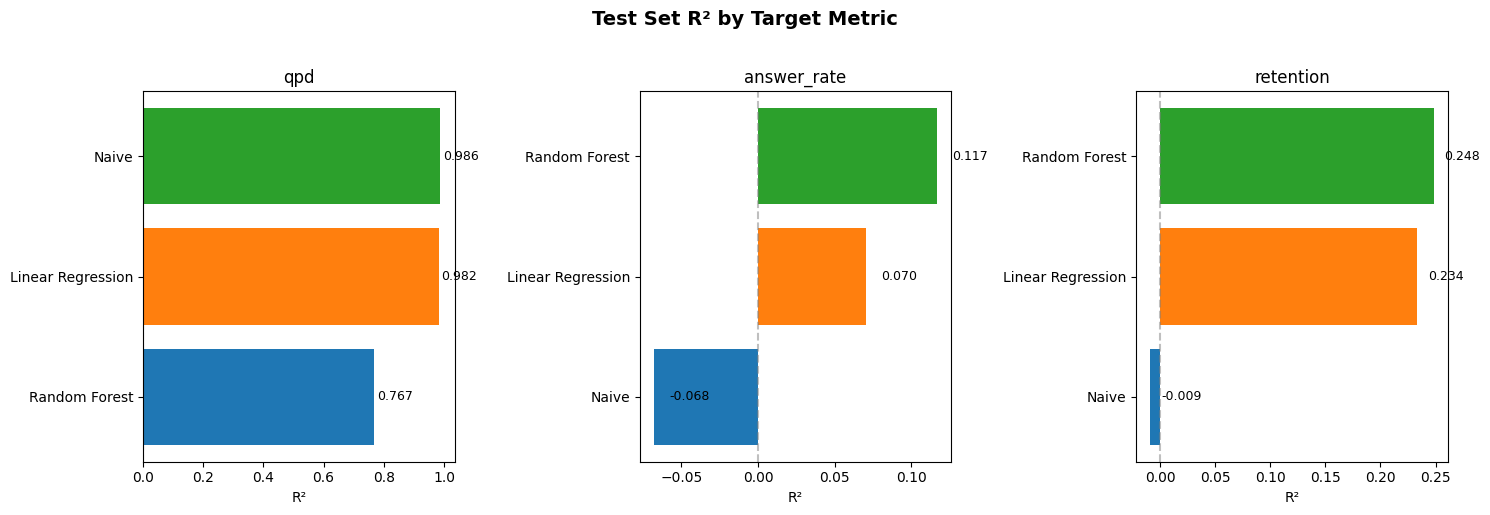


Figure saved to ../results/test_set_r2_comparison.png


In [18]:
if comparison_data:
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    targets = ['qpd', 'answer_rate', 'retention']
    colors = plt.cm.tab10.colors
    
    for ax, target in zip(axes, targets):
        target_df = comparison_df[comparison_df['Target'] == target]
        target_df = target_df.sort_values('R²', ascending=True)
        
        bars = ax.barh(target_df['Model'], target_df['R²'], color=colors[:len(target_df)])
        ax.set_xlabel('R²')
        ax.set_title(f'{target}')
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # Add value labels
        for bar, val in zip(bars, target_df['R²']):
            ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=9)
    
    plt.suptitle('Test Set R² by Target Metric', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'test_set_r2_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nFigure saved to {RESULTS_DIR / 'test_set_r2_comparison.png'}")

## 8. Save Results

In [19]:
import json

# Prepare results for saving
results_to_save = {
    'test_samples': len(test_dataset),
    'models': {}
}

for model_name, results in all_model_results.items():
    results_to_save['models'][model_name] = {
        'metrics': {}
    }
    
    for metric in ['qpd', 'answer_rate', 'retention']:
        if metric in results:
            results_to_save['models'][model_name]['metrics'][metric] = {
                'mae': float(results[metric]['mae']),
                'rmse': float(results[metric]['rmse']),
                'r2': float(results[metric]['r2'])
            }
    
    # Add mean metrics
    metrics_list = [results[m] for m in ['qpd', 'answer_rate', 'retention'] if m in results]
    if metrics_list:
        results_to_save['models'][model_name]['mean'] = {
            'mae': float(np.mean([m['mae'] for m in metrics_list])),
            'rmse': float(np.mean([m['rmse'] for m in metrics_list])),
            'r2': float(np.mean([m['r2'] for m in metrics_list]))
        }

# Save to JSON
output_path = RESULTS_DIR / 'test_set_results.json'
with open(output_path, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"Results saved to {output_path}")

Results saved to ../results/test_set_results.json


## 9. Summary

In [13]:
print("\n" + "="*70)
print("TEST SET EVALUATION SUMMARY")
print("="*70)
print(f"\nTest set size: {len(test_dataset)} samples")
print(f"Test period: 2022-10 to 2023-09")
print(f"\nModels evaluated: {len(all_model_results)}")

if all_model_results:
    # Find best model by mean R²
    best_model = None
    best_r2 = -float('inf')
    
    for model_name, results in all_model_results.items():
        mean_r2 = np.mean([results[m]['r2'] for m in ['qpd', 'answer_rate', 'retention'] if m in results])
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_model = model_name
    
    print(f"\nBest model by mean R²: {best_model}")
    print(f"  Mean R²: {best_r2:.4f}")
    
    # Best per-target
    print(f"\nBest model per target:")
    for target in ['qpd', 'answer_rate', 'retention']:
        best_target_model = None
        best_target_r2 = -float('inf')
        
        for model_name, results in all_model_results.items():
            if target in results and results[target]['r2'] > best_target_r2:
                best_target_r2 = results[target]['r2']
                best_target_model = model_name
        
        print(f"  {target}: {best_target_model} (R² = {best_target_r2:.4f})")

print("\n" + "="*70)


TEST SET EVALUATION SUMMARY

Test set size: 2002 samples
Test period: 2022-10 to 2023-09

Models evaluated: 3

Best model by mean R²: Linear Regression
  Mean R²: 0.4286

Best model per target:
  qpd: Naive (Current) (R² = 0.9859)
  answer_rate: Random Forest (R² = 0.1168)
  retention: Random Forest (R² = 0.2482)

